# Optimization benchmarking

Plotting benchmark result.

In [11]:
import sys
import numpy as np

sys.path.append('../')
from qwopt.compiler import composer
from qwopt.benchmark import fidelity as fid
from qiskit import transpile

## 1. Multi step of 4 node graph with one partition

### Check points
- How to decrease the fidelity over the number of steps
- The number of operations

### Count operations

#### Without any optimizations

Circuit is validated!
two qubit gates:  211 / one qubit gates:  274
Circuit is validated!
two qubit gates:  422 / one qubit gates:  549
Circuit is validated!
two qubit gates:  633 / one qubit gates:  824
Circuit is validated!
two qubit gates:  844 / one qubit gates:  1099
Circuit is validated!
two qubit gates:  1055 / one qubit gates:  1374
Circuit is validated!
two qubit gates:  1266 / one qubit gates:  1649
Circuit is validated!
two qubit gates:  1477 / one qubit gates:  1924
Circuit is validated!
two qubit gates:  1688 / one qubit gates:  2199
Circuit is validated!
two qubit gates:  1899 / one qubit gates:  2474


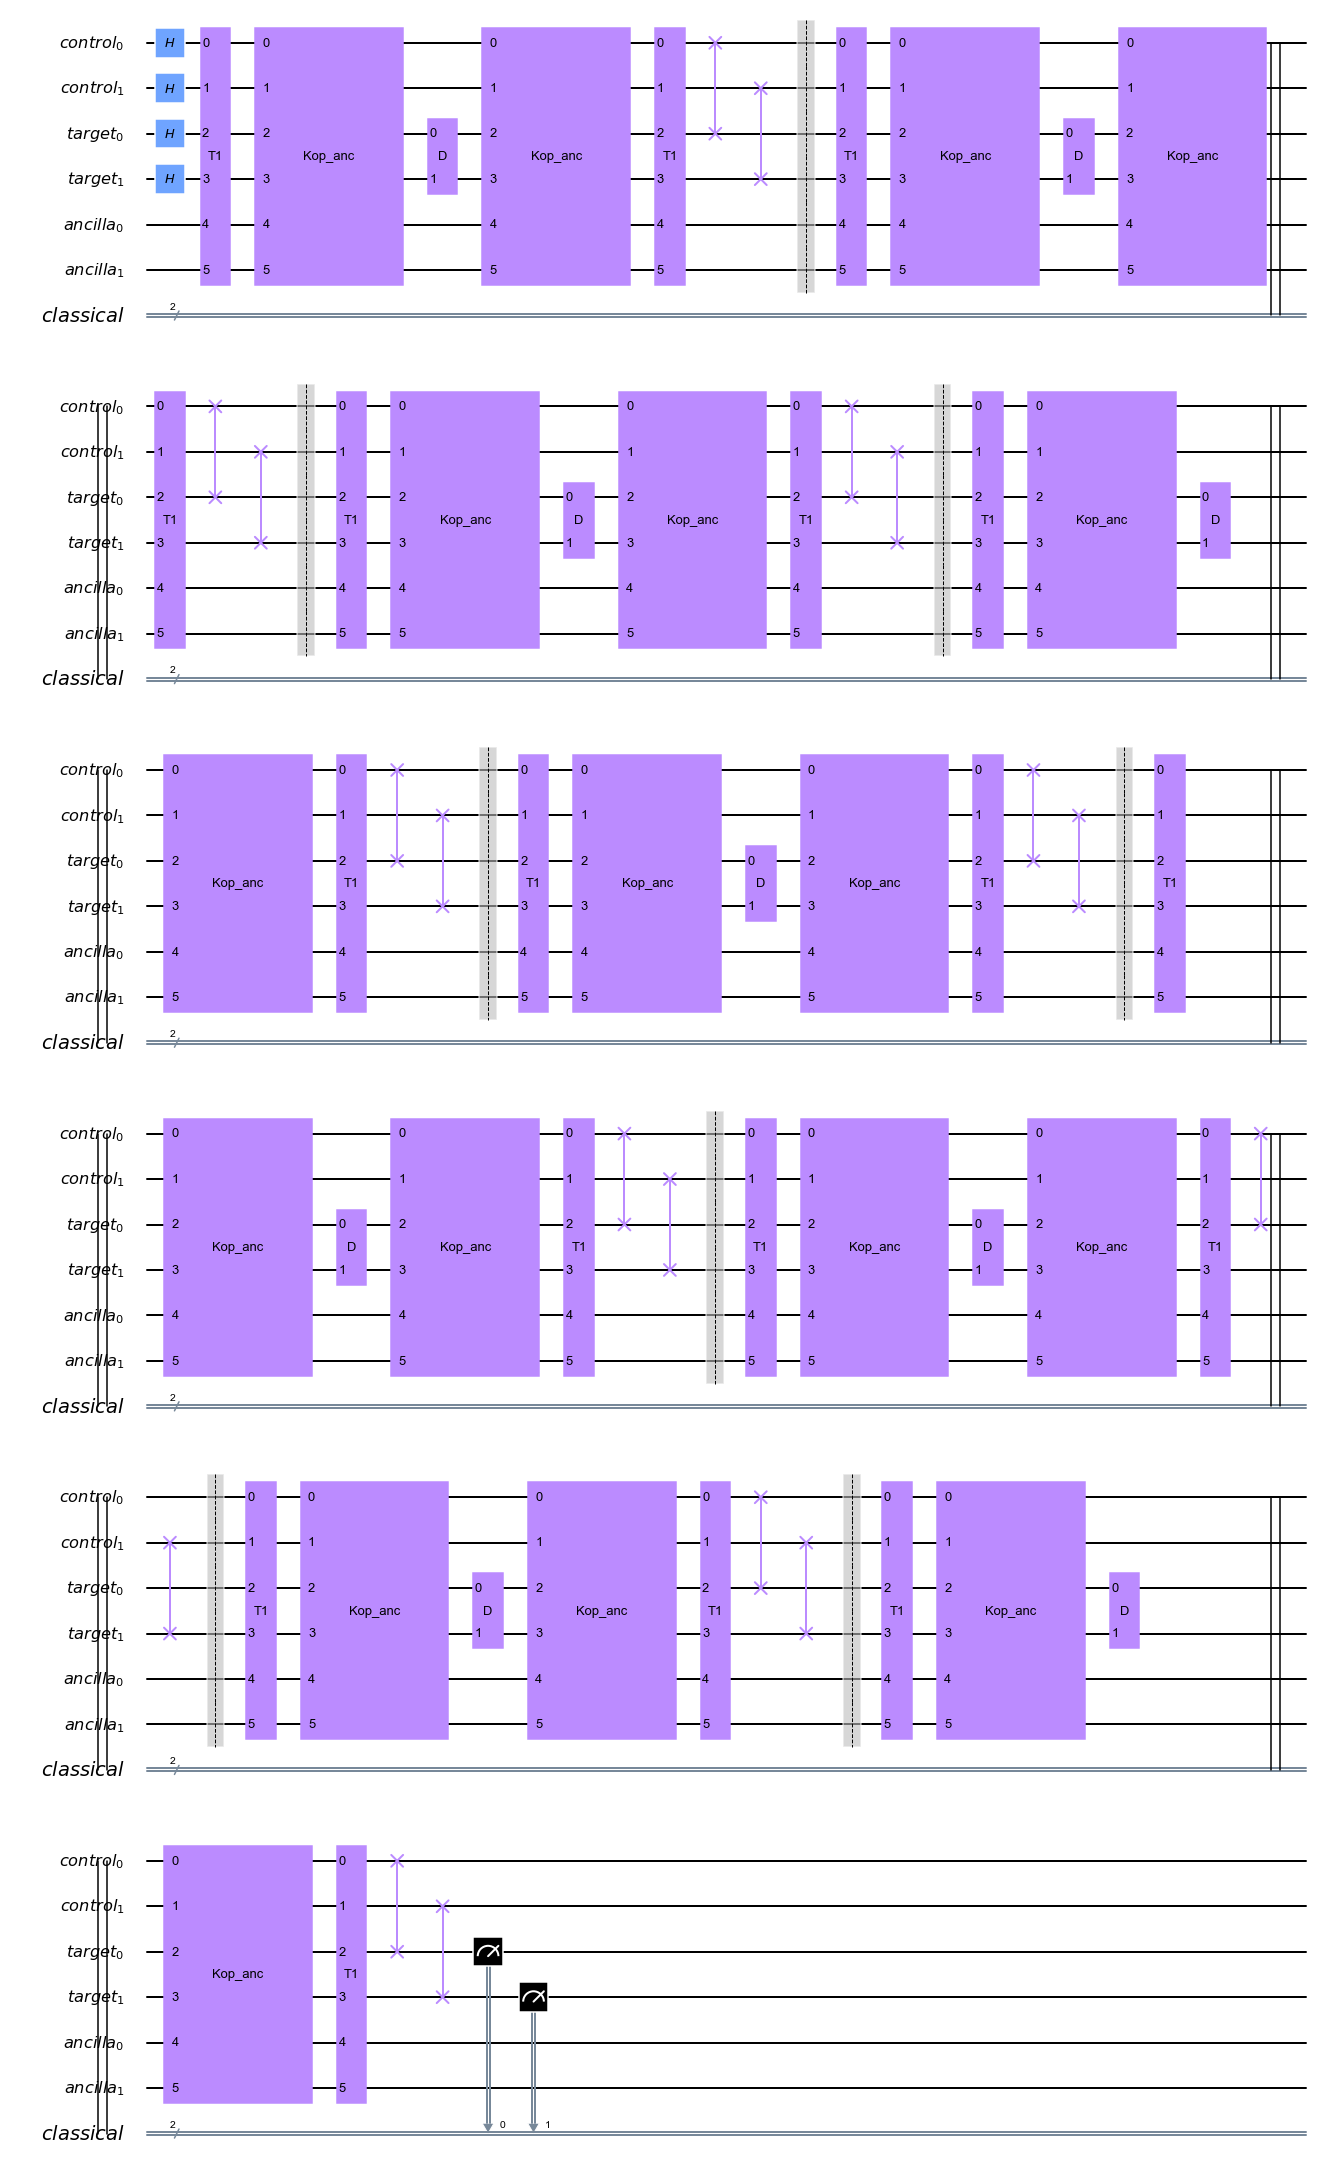

In [12]:
target_graph = np.array([[0, 1, 0, 1],
                                [0, 0, 1, 0],
                                [0, 1, 0, 1],
                                [0, 0, 1, 0]])
prob_dist = target_graph/2
for step in range(1, 10):
    qc = composer.CircuitComposer(target_graph, prob_dist, step).qw_circuit(optimization=False)
    nqc = transpile(qc, basis_gates=['cx', 'u3'])
    nc = nqc.count_ops()
    print('two qubit gates: ', nc.get('cx', 0), '/ one qubit gates: ', nc.get('u3', 0)+nc.get('u2', 0)+nc.get('u1', 0))
qc.draw(output='mpl')

#### Fidelity decrese

In [ ]:
fid_analysis = fid.FidelityAnalyzer(0, np.arange(0, 0.1, 0.01), [2, 3], extime=10, shots=10000)
fidelity = fid_analysis.fidelity_drop(qc)

OrderedDict([('u3', 3280), ('cx', 1899), ('barrier', 80), ('measure', 2)])



 50%|█████     | 5/10 [03:12<03:07, 37.54s/it]

In [ ]:
print(fidelity)

#### With optimizations

## 2. Multi step of 8 node graph with one partition

## 3. Multi step of 8 node graph with multi partition

## 4. Multi step of 1024 node graph with multi partition